In [1]:
# Data
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer,r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from joblib import dump
from statsmodels.tsa.arima.model import ARIMA # <---- Predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("stocks.csv")
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [3]:
def get_info_df(df):
    # Información básica sobre el DataFrame
    df_info = pd.DataFrame({'Column': df.columns,
                            'No_Nulls': df.notnull().sum().values,
                            'No_Unique': df.nunique().values,
                            'Type': df.dtypes.values},
                           index=range(1, len(df.columns)+1))
    
    return df_info
get_info_df(df)

,Column,No_Nulls,No_Unique,Type
1,Ticker,248,4,object
2,Date,248,62,object
3,Open,248,244,float64
4,High,248,248,float64
5,Low,248,248,float64
6,Close,248,244,float64
7,Adj Close,248,244,float64
8,Volume,248,248,int64


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,215.252093,217.919662,212.697452,215.381674,215.362697,3.208210e+07
std,91.691315,92.863023,90.147881,91.461989,91.454750,2.233590e+07
min,89.540001,90.129997,88.860001,89.349998,89.349998,2.657900e+06
25%,135.235004,137.440004,134.822495,136.347498,136.347498,1.714180e+07
50%,208.764999,212.614998,208.184998,209.920006,209.920006,2.734000e+07
75%,304.177505,307.565002,295.437500,303.942505,303.942505,4.771772e+07
max,372.410004,373.829987,361.739990,366.829987,366.829987,1.133164e+08


In [5]:
df.Ticker.value_counts()


Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date'])


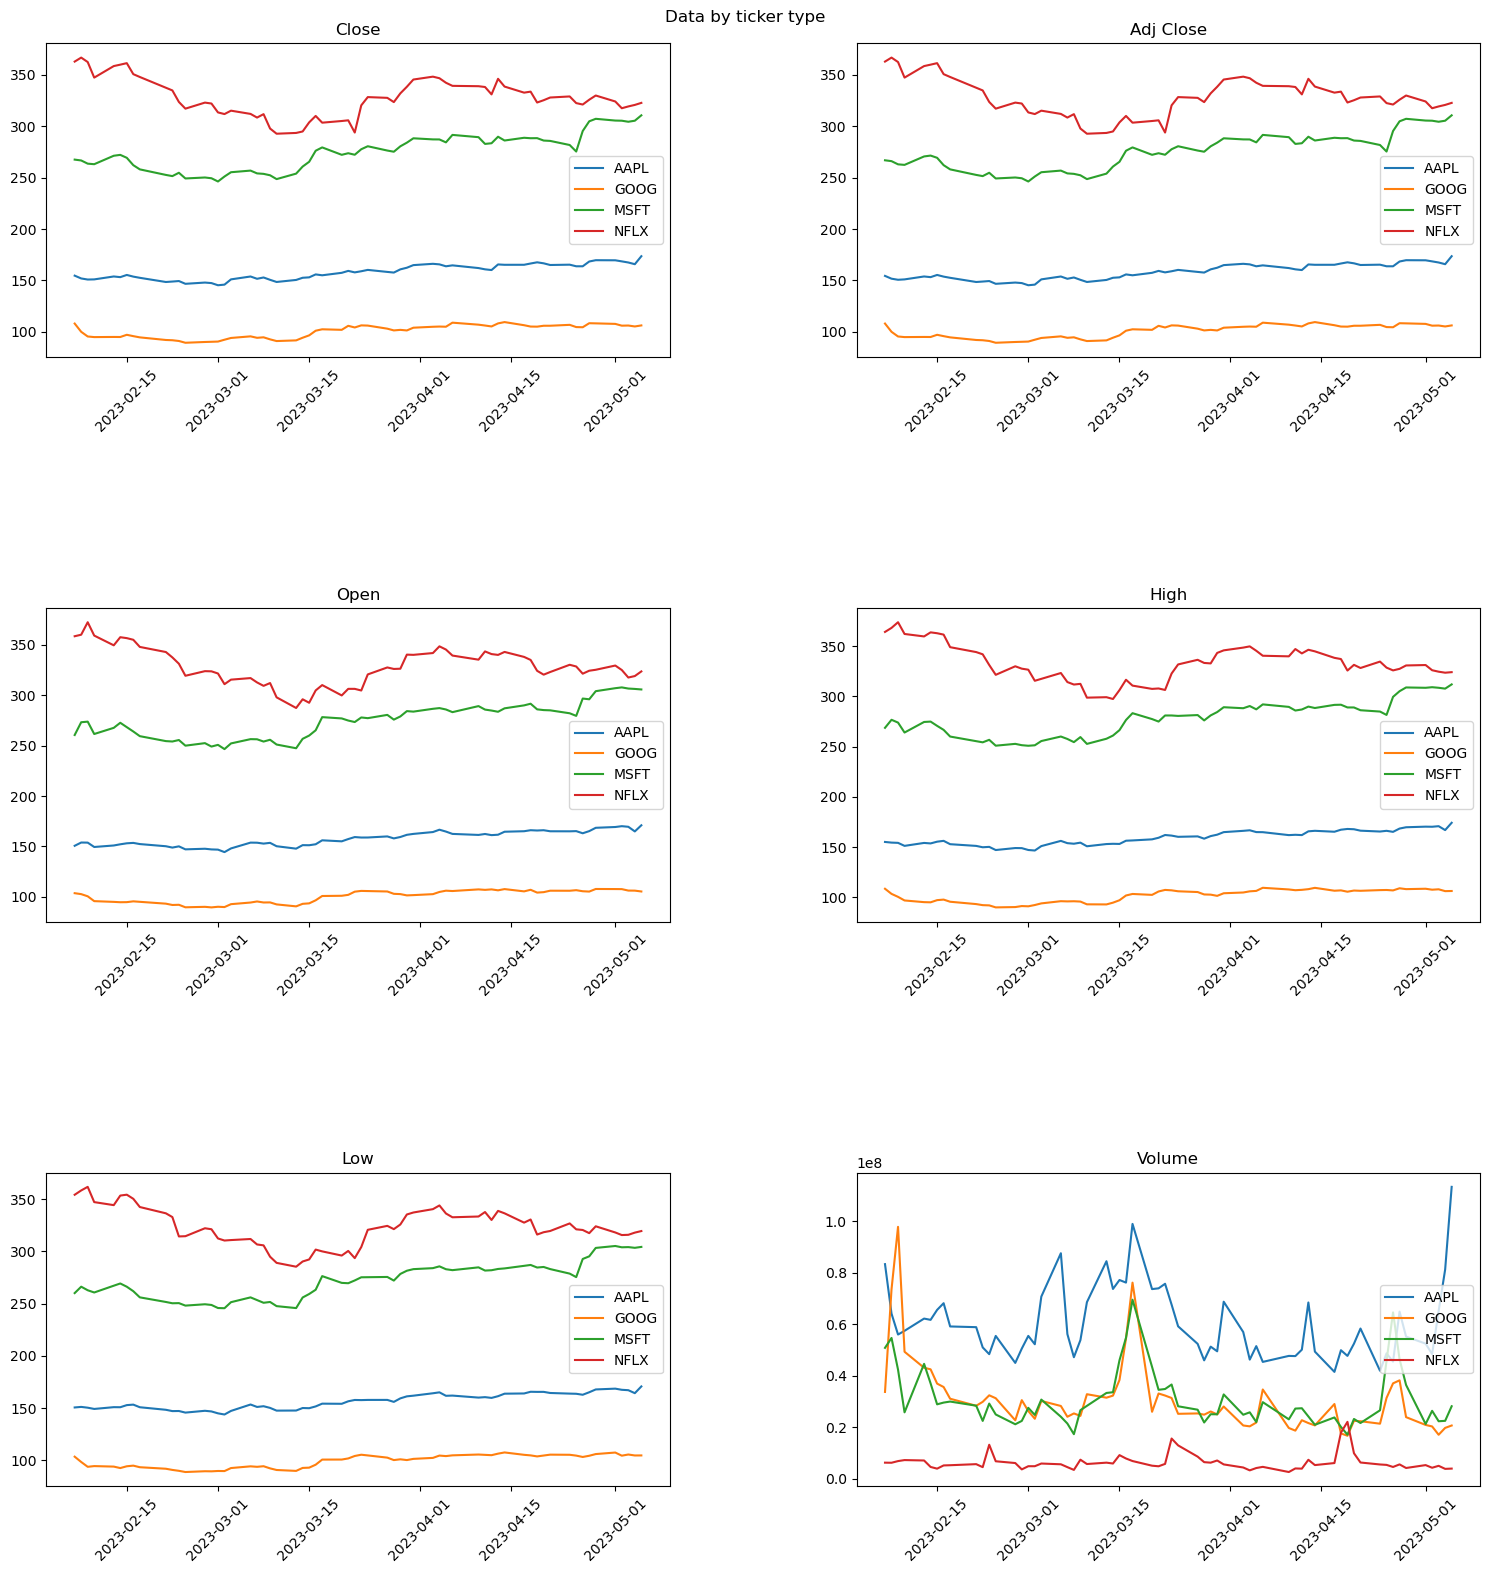

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(15, 16))
fig.suptitle('Data by ticker type')
cols = ['Close', 'Adj Close','Open', 'High', 'Low', 'Volume']
for i,col in enumerate(cols):
    row = i // 2
    col = i % 2
    for ticker, data in df.groupby('Ticker'):
        axs[row, col].plot(data['Date'], data[cols[i]], label=ticker)
    axs[row, col].set_title(cols[i])
    axs[row, col].legend(loc='right')
    axs[row, col].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.8)
plt.show()

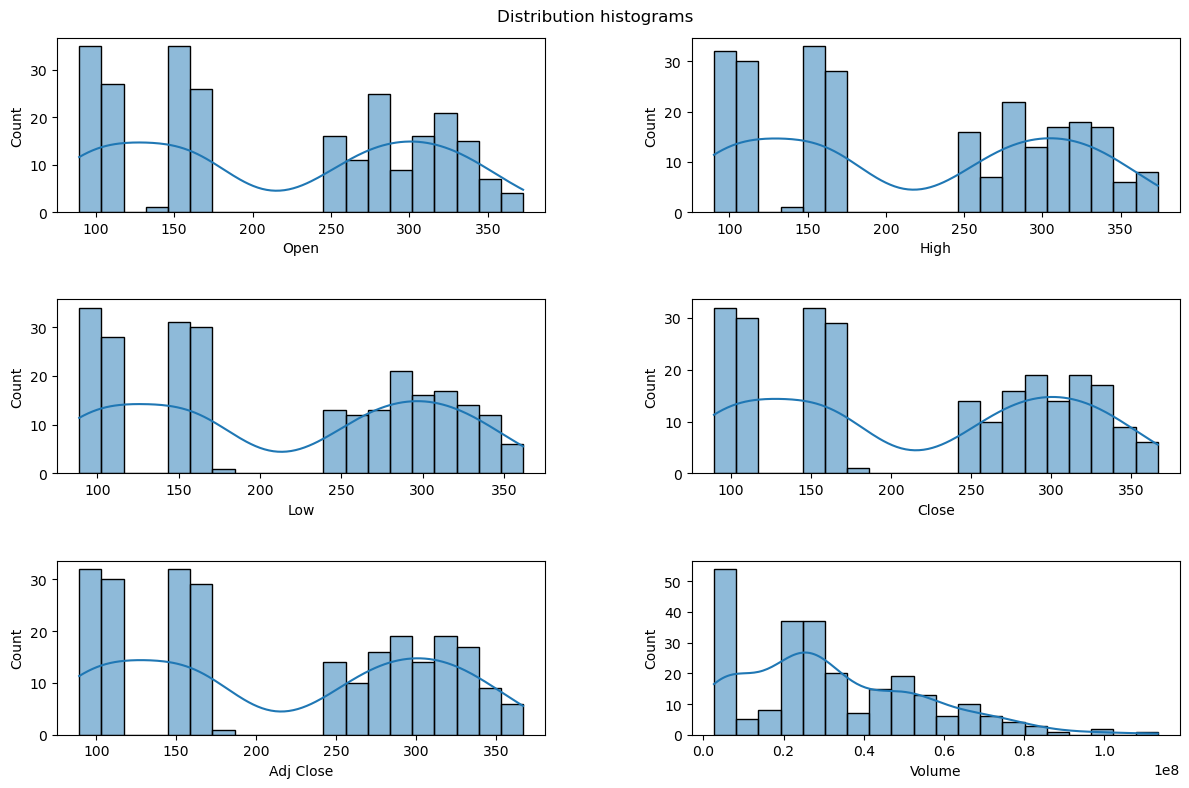

In [8]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Distribution histograms')

for i in range(len(cols)):
    row = i // 2
    col = i % 2
    sns.histplot(df[cols[i]], bins=20, kde=True, ax=axs[row, col])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [9]:
grouped_ticker_close = df.pivot_table(index='Date', columns='Ticker', values='Close')


In [10]:
grouped_ticker_close

Ticker,AAPL,GOOG,MSFT,NFLX
Date,,,,
2023-02-07,154.649994,108.040001,267.559998,362.950012
2023-02-08,151.919998,100.000000,266.730011,366.829987
2023-02-09,150.869995,95.459999,263.619995,362.500000
2023-02-10,151.009995,94.860001,263.100006,347.359985
2023-02-13,153.850006,95.000000,271.320007,358.570007
...,...,...,...,...
2023-05-01,169.589996,107.709999,305.559998,324.119995
2023-05-02,168.539993,105.980003,305.410004,317.549988
2023-05-03,167.449997,106.120003,304.399994,319.299988


In [11]:
volatility = grouped_ticker_close.std()



In [12]:
volatility

Ticker
AAPL     7.360485
GOOG     6.279464
MSFT    17.676231
NFLX    18.554419
dtype: float64

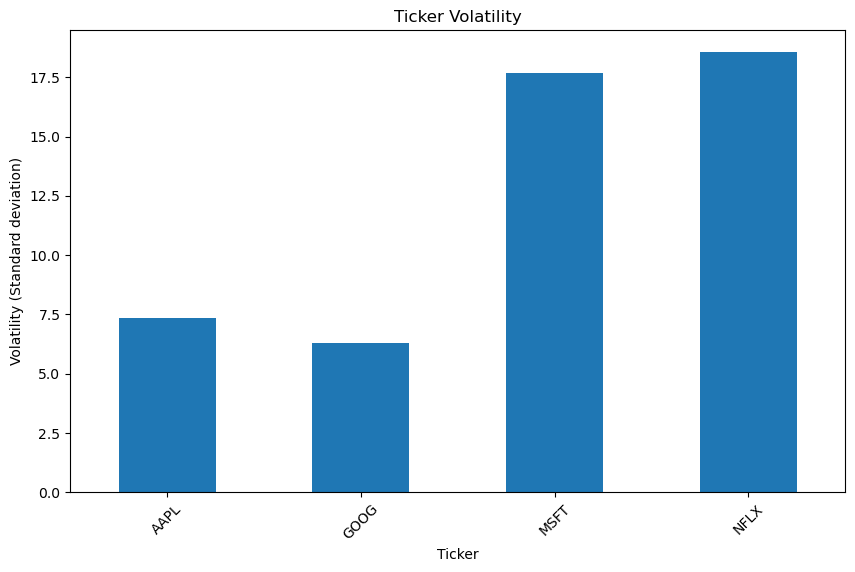

In [13]:
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.title('Ticker Volatility')
plt.xlabel('Ticker')
plt.ylabel('Volatility (Standard deviation)')
plt.xticks(rotation=45)
plt.show()

In [14]:
correlation_matrix = grouped_ticker_close.corr()



In [15]:
correlation_matrix

Ticker,AAPL,GOOG,MSFT,NFLX
Ticker,,,,
AAPL,1.000000,0.901662,0.953037,0.154418
GOOG,0.901662,1.000000,0.884527,0.201046
MSFT,0.953037,0.884527,1.000000,0.191273
NFLX,0.154418,0.201046,0.191273,1.000000


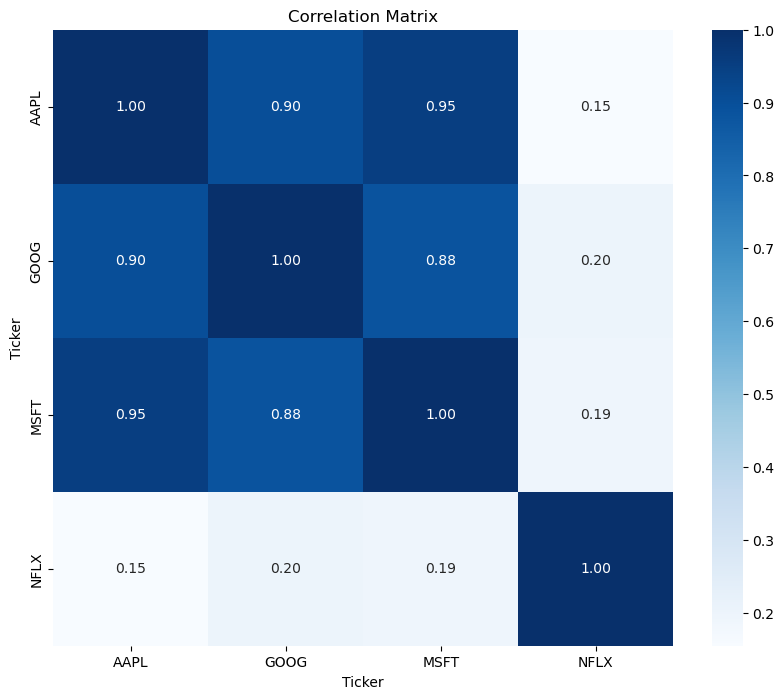

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [17]:
df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000
...,...,...,...,...,...,...,...,...
243,GOOG,2023-05-01,107.720001,108.680000,107.500000,107.709999,107.709999,20926300
244,GOOG,2023-05-02,107.660004,107.730003,104.500000,105.980003,105.980003,20343100
245,GOOG,2023-05-03,106.220001,108.129997,105.620003,106.120003,106.120003,17116300
246,GOOG,2023-05-04,106.160004,106.300003,104.699997,105.209999,105.209999,19780600


In [18]:
df['Daily Return'] = df.groupby('Ticker')['Close'].pct_change()



In [19]:
df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,NaN
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,-0.017653
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100,-0.006912
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700,0.000928
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000,0.018807
...,...,...,...,...,...,...,...,...,...
243,GOOG,2023-05-01,107.720001,108.680000,107.500000,107.709999,107.709999,20926300,-0.004713
244,GOOG,2023-05-02,107.660004,107.730003,104.500000,105.980003,105.980003,20343100,-0.016062
245,GOOG,2023-05-03,106.220001,108.129997,105.620003,106.120003,106.120003,17116300,0.001321
246,GOOG,2023-05-04,106.160004,106.300003,104.699997,105.209999,105.209999,19780600,-0.008575


In [20]:
volatility = df.groupby('Ticker')['Daily Return'].std()

risk_return_df = pd.DataFrame({'Volatility': volatility,
                               'Average Return': df.groupby('Ticker')['Daily Return'].mean()})



In [21]:
volatility

Ticker
AAPL    0.014152
GOOG    0.020710
MSFT    0.017881
NFLX    0.022481
Name: Daily Return, dtype: float64

In [22]:
risk_return_df

,Volatility,Average Return
Ticker,,
AAPL,0.014152,0.001991
GOOG,0.020710,-0.000067
MSFT,0.017881,0.002606
NFLX,0.022481,-0.001676


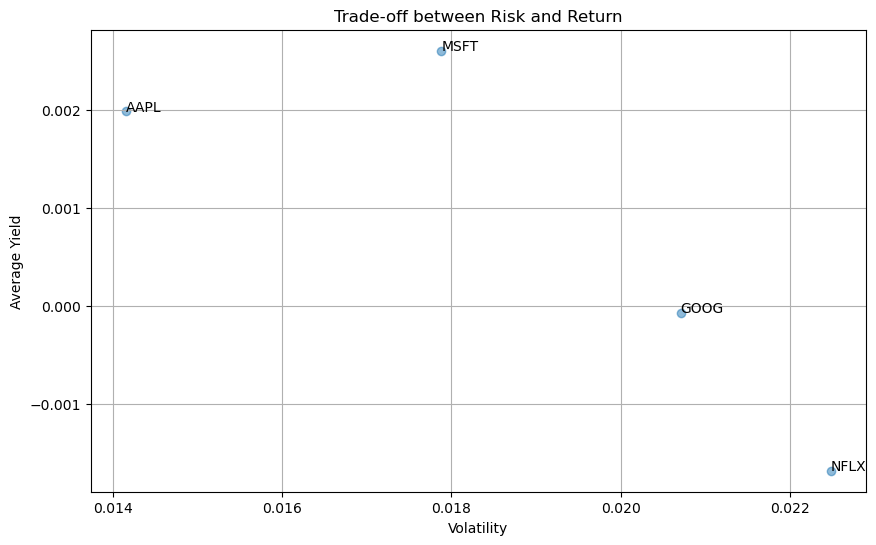

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(risk_return_df['Volatility'], risk_return_df['Average Return'], alpha=0.5)

for ticker, row in risk_return_df.iterrows():
    plt.text(row['Volatility'], row['Average Return'], ticker)

plt.title('Trade-off between Risk and Return')
plt.xlabel('Volatility')
plt.ylabel('Average Yield')
plt.grid(True)
plt.show()

In [24]:
df_apple = df[df['Ticker'] == 'AAPL']
df_apple = df_apple[["Close","Date"]]



In [25]:
df_apple

,Close,Date
0,154.649994,2023-02-07
1,151.919998,2023-02-08
2,150.869995,2023-02-09
3,151.009995,2023-02-10
4,153.850006,2023-02-13
...,...,...
57,169.589996,2023-05-01
58,168.539993,2023-05-02
59,167.449997,2023-05-03
60,165.789993,2023-05-04


In [26]:
result = seasonal_decompose(df_apple['Close'], model='multiplicative', period=30)


In [27]:
result

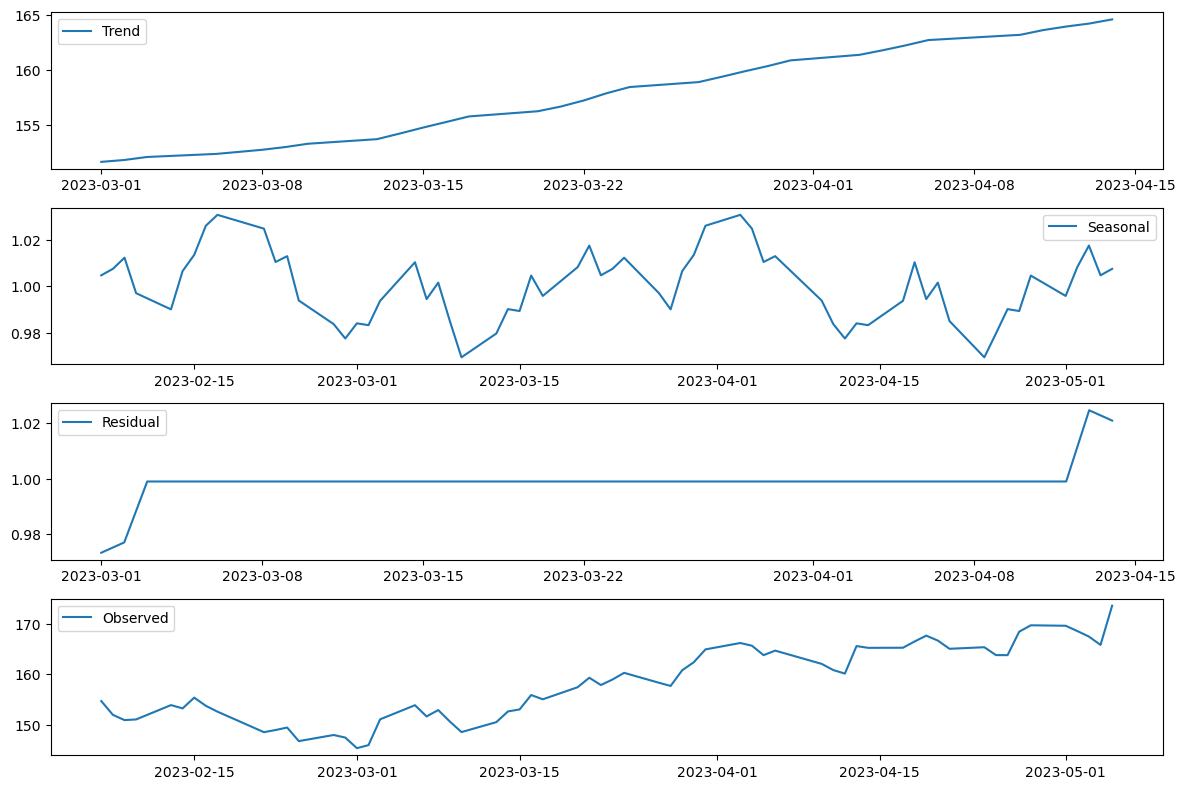

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_apple['Date'], result.trend, label='Trend')
plt.legend()
plt.subplot(412)
plt.plot(df_apple['Date'], result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(413)
plt.plot(df_apple['Date'], result.resid, label='Residual')
plt.legend()
plt.subplot(414)
plt.plot(df_apple['Date'], result.observed, label='Observed')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
time_series = df_apple['Close']



In [30]:
time_series

0     154.649994
1     151.919998
2     150.869995
3     151.009995
4     153.850006
         ...    
57    169.589996
58    168.539993
59    167.449997
60    165.789993
61    173.570007
Name: Close, Length: 62, dtype: float64

In [31]:
def test_stationarity(time_series):
    result = adfuller(time_series)
    
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] <= 0.05:
        print('The data is stationary (p-value <= 0.05)')
    else:
        print('The data is not stationary  (p-value > 0.05)')

test_stationarity(time_series)


ADF Statistic: -0.2916929059594763
p-value: 0.9266726529518915
Critical Values:
   1%: -3.542412746661615
   5%: -2.910236235808284
   10%: -2.5927445767266866
The data is not stationary  (p-value > 0.05)


## Interpretation: A growing trend is observed, indicating that the time series is not stationary. Additionally, the Dickey-Fuller test is performed to verify this.

Using first-order differencing to remove the trend.

In [32]:
df_apple["Close_diff"] = df_apple["Close"].diff()
df_apple.dropna(inplace=True)


In [33]:
test_stationarity(df_apple["Close_diff"])


ADF Statistic: -5.238103734362096
p-value: 7.3465195647668834e-06
Critical Values:
   1%: -3.552928203580539
   5%: -2.9147306250000002
   10%: -2.595137155612245
The data is stationary (p-value <= 0.05)


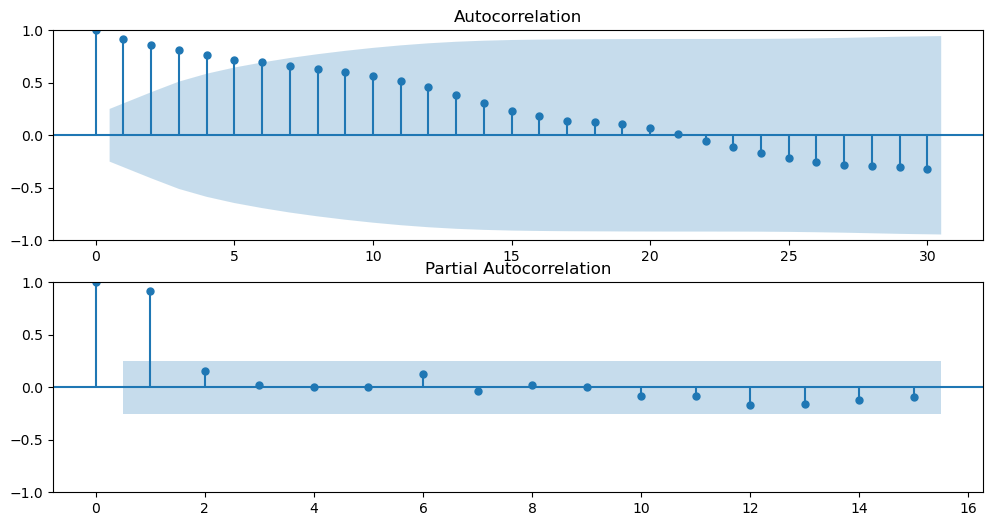

ADF Statistic: 0.704369250723779
p-value: 0.9899246633203046


In [34]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df_apple['Close'], ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(df_apple['Close'], ax=plt.gca(), lags=15)  # Adjusted lags value
plt.show()

# Augmented Dickey-Fuller test
result = adfuller(df_apple['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


In [35]:
!pip install pmdarima


In [36]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
df_apple.set_index("Date", inplace=True)



In [37]:
df_apple

,Close,Close_diff
Date,,
2023-02-08,151.919998,-2.729996
2023-02-09,150.869995,-1.050003
2023-02-10,151.009995,0.139999
2023-02-13,153.850006,2.840012
2023-02-14,153.199997,-0.650009
...,...,...
2023-05-01,169.589996,-0.089996
2023-05-02,168.539993,-1.050003
2023-05-03,167.449997,-1.089996


In [38]:
train_data, test_data = train_test_split(df_apple['Close'], train_size=0.9)


In [39]:
train_data

Date
2023-02-08    151.919998
2023-02-09    150.869995
2023-02-10    151.009995
2023-02-13    153.850006
2023-02-14    153.199997
2023-02-15    155.330002
2023-02-16    153.710007
2023-02-17    152.550003
2023-02-21    148.479996
2023-02-22    148.910004
2023-02-23    149.399994
2023-02-24    146.710007
2023-02-27    147.919998
2023-02-28    147.410004
2023-03-01    145.309998
2023-03-02    145.910004
2023-03-03    151.029999
2023-03-06    153.830002
2023-03-07    151.600006
2023-03-08    152.869995
2023-03-09    150.589996
2023-03-10    148.500000
2023-03-13    150.470001
2023-03-14    152.589996
2023-03-15    152.990005
2023-03-16    155.850006
2023-03-17    155.000000
2023-03-20    157.399994
2023-03-21    159.279999
2023-03-22    157.830002
2023-03-23    158.929993
2023-03-24    160.250000
2023-03-27    158.279999
2023-03-28    157.649994
2023-03-29    160.770004
2023-03-30    162.360001
2023-03-31    164.899994
2023-04-03    166.169998
2023-04-04    165.630005
2023-04-05    163.75

In [40]:
test_data

Date
2023-04-27    168.410004
2023-04-28    169.679993
2023-05-01    169.589996
2023-05-02    168.539993
2023-05-03    167.449997
2023-05-04    165.789993
2023-05-05    173.570007
Name: Close, dtype: float64

In [41]:
# Search the model ARIMA óptim
model = pm.auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=196.184, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=197.112, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=196.482, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=195.139, Time=0.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=196.908, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=194.537, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=196.332, Time=0.18 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=196.492, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=196.452, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.772 seconds
                                      SARIMAX Results                                       
Dep. V

In [42]:
n_periods = len(test_data)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

C:\Users\himan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
forecast

54    162.969094
55    162.980391
56    164.973054
57    164.399608
58    165.465853
59    166.621778
60    168.041648
dtype: float64

In [44]:
conf_int

array([[158.27571489, 167.66247348],
       [156.34295011, 169.61783141],
       [156.84388258, 173.10222538],
       [155.01284938, 173.78636656],
       [154.97113751, 175.9605678 ],
       [155.12539368, 178.11816256],
       [155.62413348, 180.45916231]])

In [45]:
n_periods

7

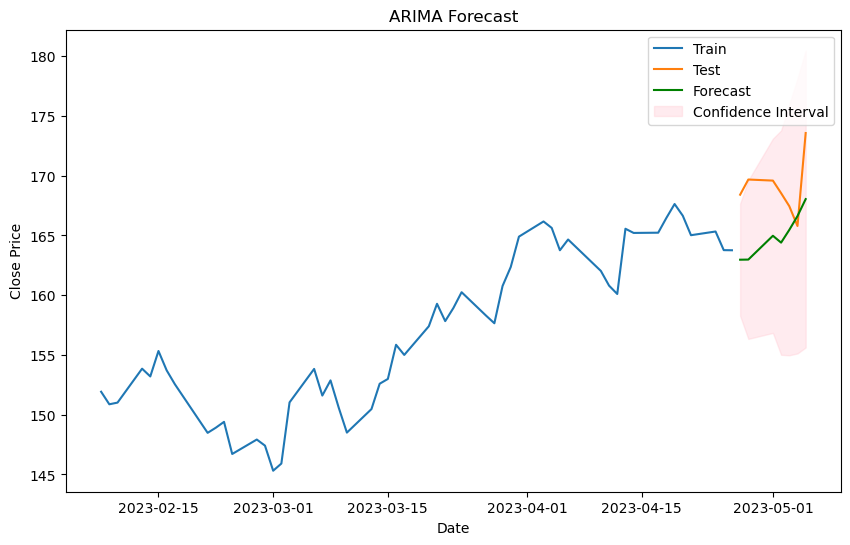

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, color='green', label='Forecast')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()